In [5]:
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from scipy.stats import norm
np.random.seed(10)

In [6]:
def branin_function_1d(X):
    # The function must receive a dictionary
    x1 = X['x1']
    
    # Branin function computation
    a = 1.
    b = 5.1 / (4.0 * math.pi * math.pi)
    c = 5. / math.pi
    r = 6.
    s = 3.
    t = 1.0 / (8.0 * math.pi)
    x2 = 2.275
    value = a * (x2 - b * x1 * x1 + c * x1 - r) ** 2 + s * (1 - t) * math.cos(x1) + s

    # The function must return the objective value (a number)
    return np.log(value)

In [7]:
def branin_function_1d(X):
    # The function must receive a dictionary
    x1 = X['x1']
    
    # Branin function computation
    a = 5
    b = 5#5.1 / (4.0 * math.pi * math.pi)
    c = 13 #5. / math.pi
    r = -5
    s = 0.1
    t = 1#1.0 / (8.0 * math.pi)
    x2 = 2.275
    value = a * (x2 - b * x1 * x1 + c * x1 - r) ** 2 + s * (1 - t) * math.cos(x1) + s

    # The function must return the objective value (a number)
    return np.log(value)

In [8]:
def branin_function_1d(X):
    # The function must receive a dictionary
    x1 = X['x1']
    
    # Branin function computation
    a = 20
    b = 1.7#5.1 / (4.0 * math.pi * math.pi)
    c = 6 #5. / math.pi
    r = 5
    s = 0.1
    t = 1#1.0 / (8.0 * math.pi)
    x2 = 2.275
    value = a * (x2 - b * x1 * x1 + c * x1 - r) ** 2 + s * (1 - t) * math.cos(x1) + s

    # The function must return the objective value (a number)
    return np.log(value)

In [9]:
def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y - 0.1) / y_std
    ei = (y_pred - best_y- 0.1) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

In [10]:
def ucb(x, gp_model, lam):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    return (y_pred + lam*y_std)

In [84]:
############################ Here we define the model an acquisition function of BOPrO ###############################
def m_g(x, gamma, gp_model):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    f_gamma = np.array([norm(mu, std).ppf(gamma) for mu, std in zip(y_pred, y_std)])
    z = (f_gamma - y_pred) / y_std
    comm_probs = []
    for mu, std, z_ in zip(y_pred, y_std, z):
        cprob = norm(mu, std).cdf(z_)
        if cprob == 0:
            comm_probs.append(1e-5)
        else:
            comm_probs.append(cprob)
    return np.array(comm_probs)

def m_b(x, gamma, gp_model):
    return 1 - m_g(x, gamma, gp_model)

def g(mu, std, beta, t, x, gp_model, gamma, use_prior=True):
    if use_prior:
        pg = norm(mu, std).pdf(x)
        pg = ((pg + 1e-8) - pg.min()) / ((pg.max()) - pg.min())
        return np.log(pg) + t/beta * np.log(m_g(x, gamma, gp_model))
    else:
        return t/beta * np.log(m_g(x, gamma, gp_model))

def b(mu, std, beta, t, x, gp_model, gamma, use_prior=True):
    if use_prior:
        pg = norm(mu, std).pdf(x)
        pg = ((pg + 1e-8) - pg.min()) / ((pg.max() + 1e-5) - pg.min())
        pb = 1 - pg
        return np.log(pb) + t/beta * np.log(m_b(x, gamma, gp_model))
    else:
        return t/beta * np.log(m_b(x, gamma, gp_model))
    
def bopro_acquisition(x, mu, std, gamma, gp_model, beta, t, use_prior=True):
    b_ = b(mu, std, beta, t, x, gp_model, gamma, use_prior)
    g_ = g(mu, std, beta, t, x, gp_model, gamma, use_prior)
    print(f"[{np.exp(b_.min())}, {np.exp(b_.max())}]")
    print(f"[{np.exp(g_.min())}, {np.exp(g_.max())}]")
    return (gamma + np.exp(b_ - g_) * (1 - gamma))**-1

[7.512692975719655e-06, 0.9999999924797861]
[3.32681928257574e-140, 0.06719899984981491]
[0.8681667220050269, 1.0]
[5.817468786634381e-140, 0.13183327799497307]


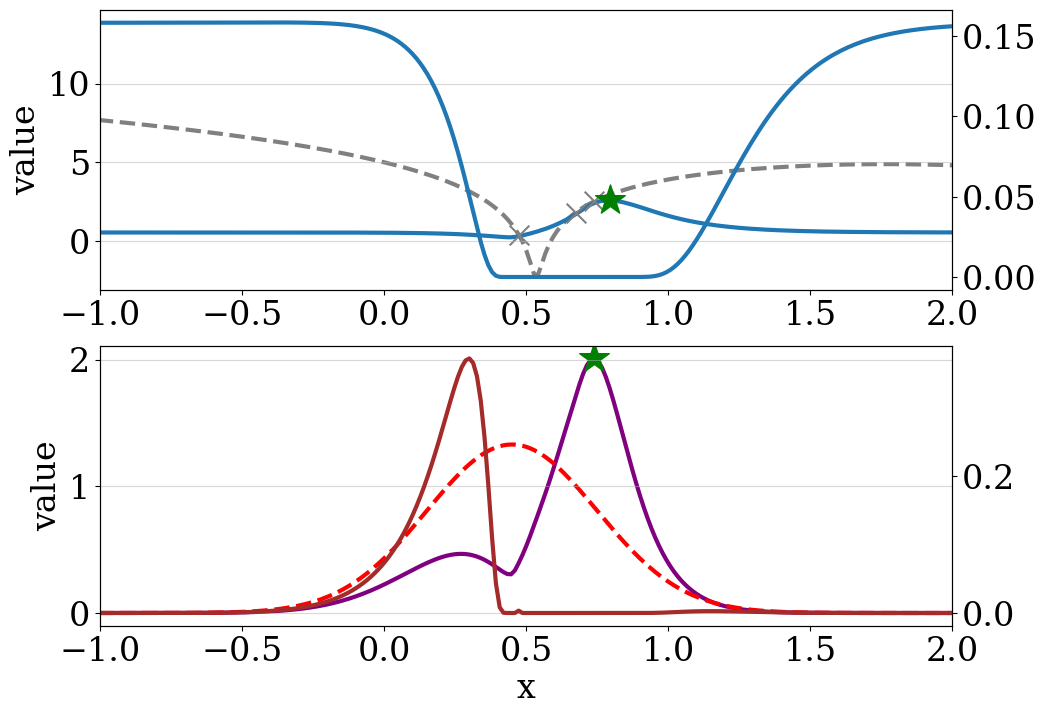

The 1d Branin function has one global optimum at x1 = π
(x, y) at minimum is: (3.141592653589793,2.1573679802677392)
809
805


In [109]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24
point_size = matplotlib.rcParams['lines.markersize']**2.8
point_size_optimum = matplotlib.rcParams['lines.markersize']**2

optimum = math.pi
value_at_optimum=branin_function_1d({'x1': optimum})
# Sample 1000 (x,y) pairs from the function to plot its curve
branin_line_xs = np.linspace(-10, 10, 1500)
branin_line_ys = []
for x in branin_line_xs:
    y = branin_function_1d({'x1': x})
    branin_line_ys.append(y)

x, y = np.array(branin_line_xs), np.array(branin_line_ys)
idx = np.random.choice(np.arange(0, len(x)), size=5)
idx = [960, 990, 1020]
idx = [785, 800, 805, 970]
x_train, y_train = x[idx], y[idx]
#kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel = 1 *  Matern(length_scale=1.0, length_scale_bounds=(1e-1, 1e1), nu=1.5)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x_train.reshape(-1, 1), y_train)

mean_prediction, std_prediction = gaussian_process.predict(x.reshape(-1, 1), return_std=True)
ei = expected_improvement(x, gaussian_process, y_train.min())
#idx = np.argwhere(ei == min(ei)).flatten()[0]

wmu, wsigma = 0.45, 0.3 #0.32, 0.3
#prior_dist = lambda x: norm(wmu, wsigma).pdf(x)
densities = norm(wmu, wsigma).pdf(x)
wmu_bopro, wsigma_bopro = 0.45, 0.3
densities_bopro = norm(wmu_bopro, wsigma_bopro).pdf(x)
weighted_ei = ei * densities
bp_ac = bopro_acquisition(x, wmu_bopro, wsigma_bopro, 0.05, gaussian_process, 5, len(y_train) + 1)
bp_ac_no_prior =  bopro_acquisition(x, wmu_bopro, wsigma_bopro, 0.05, gaussian_process, 5, len(y_train) + 1, False)
plot_start_idx = 0
plot_end_idx = 1500
branin_line_ys = np.array(branin_line_ys)
#fig, ax = plt.subplots(figsize=(12, 9.2))
fig, ax = plt.subplots(2, figsize=(11, 8))
#plt.subplot(211)
ax[0].plot(branin_line_xs[plot_start_idx:plot_end_idx], branin_line_ys[plot_start_idx:plot_end_idx], label="1D Branin Function", linestyle='dashed', color='grey', linewidth=3, zorder=0)
ax[0].scatter(x_train, y_train, label="Observations", color='grey', marker='x', s=200, zorder=1)
#plt.plot(x, mean_prediction, label="Mean prediction")
ax[0].plot(x[plot_start_idx:plot_end_idx], ei[plot_start_idx:plot_end_idx], label="EI", linewidth=3, zorder=0)
ax0 = ax[0].twinx()
ax0.plot(x[plot_start_idx:plot_end_idx], bp_ac_no_prior[plot_start_idx:plot_end_idx], label="BOPrO Acquisition", linewidth=3, zorder=0)
max_idx = np.argwhere(ei == ei.max()).flatten()[0]
ax[0].scatter([x[max_idx]], [ei[max_idx]], label='Next configuration', color="green", marker="*", s=500, zorder=1)
ax[0].set_ylabel("value")
ax[0].grid(axis='y', alpha=0.5)
ax[0].set_xlim(-1, 2)
#plt.ylim(-3, 10)
#plt.fill_between(
#    x.ravel(),
#    mean_prediction - 1.96 * std_prediction,
#    mean_prediction + 1.96 * std_prediction,
#   alpha=0.5,
#    label=r"95% confidence interval",
#)
#plt.legend(loc='upper left')

#plt.subplot(212)
max_idx = np.argwhere(weighted_ei == weighted_ei.max()).flatten()[0]
ax[1].plot(x[plot_start_idx:plot_end_idx], weighted_ei[plot_start_idx:plot_end_idx], color='purple', label="Weighted EI", linewidth=3, zorder=0)
ax1 = ax[1].twinx()
ax1.plot(x[plot_start_idx:plot_end_idx], bp_ac[plot_start_idx:plot_end_idx], color='brown', label="BOPrO Acquisition", linewidth=3, zorder=0)
ax[1].plot(x[plot_start_idx:plot_end_idx], densities[plot_start_idx:plot_end_idx], color='red', label="User prior", linewidth=3, zorder=0, linestyle='dashed')
#ax[1].plot(x[plot_start_idx:plot_end_idx], densities_bopro[plot_start_idx:plot_end_idx], color='green', label="User prior", linewidth=3, zorder=0, linestyle='dashed')
ax[1].scatter([x[max_idx]], [weighted_ei[max_idx]], color="green", marker="*", s=500, zorder=1)

# Mark the known optimum on the curve
#plt.scatter(optimum, value_at_optimum, s=point_size_optimum, marker='o', color="black", label="Minimum")
#ax.tick_params(length=12., width=3., direction='inout')
#ax[1].legend(loc='upper left')
ax[1].set_xlabel("x")
ax[1].set_ylabel("value")
#plt.ylim(-0.05, 0.5)
ax[1].set_xlim(-1, 2)
ax[1].grid(axis='y', alpha=0.5)

plt.savefig('./pibo_failure.pdf', bbox_inches='tight')
plt.show()
print("The 1d Branin function has one global optimum at x1 = \u03C0", flush=True)
print("(x, y) at minimum is: ("+str(optimum)+","+str(value_at_optimum)+")", flush=True)
print(np.argmax(ei))
print(np.argmax(weighted_ei))

# TODO: Rethink how to show that: To stress more the fact that uncertainty is not incorporated, repeat process and maybe show distributions of selected points (also vs. PC)

In [30]:
x[809] - x[804]

0.06671114076050699

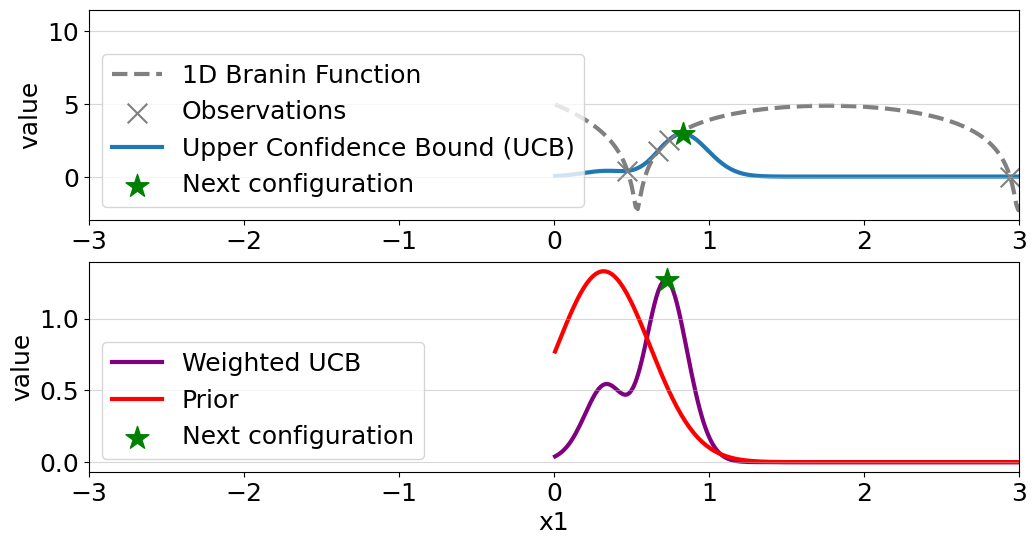

The 1d Branin function has one global optimum at x1 = π
(x, y) at minimum is: (3.141592653589793,2.1573679802677392)


In [708]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 18
point_size = matplotlib.rcParams['lines.markersize']**2.8
point_size_optimum = matplotlib.rcParams['lines.markersize']**2

optimum = math.pi
value_at_optimum=branin_function_1d({'x1': optimum})
# Sample 1000 (x,y) pairs from the function to plot its curve
branin_line_xs = np.linspace(-10, 10, 1500)
branin_line_ys = []
for x in branin_line_xs:
    y = branin_function_1d({'x1': x})
    branin_line_ys.append(y)

x, y = np.array(branin_line_xs), np.array(branin_line_ys)
idx = np.random.choice(np.arange(0, len(x)), size=5)
idx = [ 950, 1020,  1100]
idx = [785, 800, 805, 970]
x_train, y_train = x[idx], y[idx]
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x_train.reshape(-1, 1), y_train)

mean_prediction, std_prediction = gaussian_process.predict(x.reshape(-1, 1), return_std=True)
ei = ucb(x, gaussian_process, y_train.min())
idx = np.argwhere(ei == min(ei)).flatten()[0]

wmu, wsigma = 0.32, 0.3
densities = norm(wmu, wsigma).pdf(x)
weighted_ei = ei * densities
plot_start_idx = 750
plot_end_idx = 1300
branin_line_ys = np.array(branin_line_ys)
#fig, ax = plt.subplots(figsize=(12, 9.2))
plt.subplot(211)
plt.plot(branin_line_xs[plot_start_idx:plot_end_idx], branin_line_ys[plot_start_idx:plot_end_idx], label="1D Branin Function", linestyle='dashed', color='grey', linewidth=3, zorder=0)
plt.scatter(x_train, y_train, label="Observations", color='grey', marker='x', s=200, zorder=1)
#plt.plot(x, mean_prediction, label="Mean prediction")
plt.plot(x[plot_start_idx:plot_end_idx], ei[plot_start_idx:plot_end_idx], label="Upper Confidence Bound (UCB)", linewidth=3, zorder=0)
max_idx = np.argwhere(ei == ei.max()).flatten()[0]
plt.scatter([x[max_idx]], [ei[max_idx]], label="Next configuration", color="green", marker="*", s=300, zorder=1)
plt.ylabel("value")
plt.grid(axis='y', alpha=0.5)
plt.xlim(-3, 3)
plt.legend(loc='lower left')

plt.subplot(212)
max_idx = np.argwhere(weighted_ei == weighted_ei.max()).flatten()[0]
plt.plot(x[plot_start_idx:plot_end_idx], weighted_ei[plot_start_idx:plot_end_idx], color='purple', label="Weighted UCB", linewidth=3, zorder=0)
#plt.fill_between(
#    x.ravel(),
#    mean_prediction - 1.96 * std_prediction,
#    mean_prediction + 1.96 * std_prediction,
#    alpha=0.5,
#    label=r"95% confidence interval",
#)
plt.plot(x[plot_start_idx:plot_end_idx], densities[plot_start_idx:plot_end_idx], color='red', label="Prior", linewidth=3, zorder=0)
plt.scatter([x[max_idx]], [weighted_ei[max_idx]], label="Next configuration", color="green", marker="*", s=300, zorder=1)

# Mark the known optimum on the curve
#plt.scatter(optimum, value_at_optimum, s=point_size_optimum, marker='o', color="black", label="Minimum")
#ax.tick_params(length=12., width=3., direction='inout')
plt.legend(loc='lower left')
plt.xlabel("x1")
plt.ylabel("value")
#plt.ylim(-0.5, 0.5)
plt.xlim(-3, 3)
plt.grid(axis='y', alpha=0.5)

plt.show()
print("The 1d Branin function has one global optimum at x1 = \u03C0", flush=True)
print("(x, y) at minimum is: ("+str(optimum)+","+str(value_at_optimum)+")", flush=True)

In [111]:
import pandas as pd
import numpy as np
import os

<Axes: >

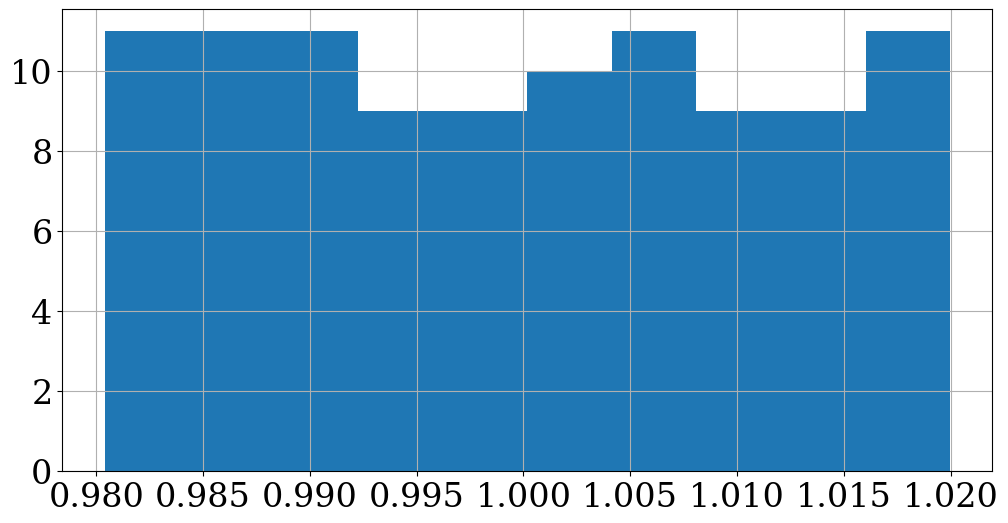

In [122]:
files = os.listdir('../data/logs/jahs_cifar10_pibo/')
rnd_idx = np.random.choice(np.array(len(files)), size=1).flatten()[0]
f = files[rnd_idx]
df = pd.read_csv(f'../data/logs/jahs_cifar10_pibo/{f}', index_col=0)
df.loc[:100, 'Resolution'].hist()